---
# Cairo University Faculty of Engineering
## Deep Learning
## Assignment 2

---

Please write your full name here
- **Name** : "Alaa Yasser Mahmoud"

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import math

from sklearn.datasets import make_blobs  #To generate artificial data
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

**Use TensorFlow unless mentioned otherwise**

# Part 2: Regression

In this part, (**we will implement the entire linear regression method from scratch,
including the data pipeline, the model,
the loss function, and the minibatch stochastic gradient descent optimizer.**)
You will rely only on tensors and auto differentiation.


we will use $n$ to denote
the number of examples in our dataset.
We index the data examples by $i$, denoting each input
as $\mathbf{x}^{(i)} = [x_1^{(i)}, x_2^{(i)}]^\top$
and the corresponding label as $y^{(i)}$.


**Linear Model**


We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.

For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix-vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$


**Loss Function**

The most popular loss function in regression problems
is the squared error.
When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the squared error is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$


A regression problem for a one-dimensional case is shown below:

<img src="https://i.ibb.co/8cXVC31/fit-linreg.png" alt="fit-linreg" border="0">

To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set.

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we want to find parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$


**Minibatch Stochastic Gradient Descent**


The key technique for optimizing models
consists of iteratively reducing the error
by updating the parameters in the direction
that incrementally lowers the loss function --> *gradient descent*.

We will settle for sampling a random minibatch of examples
every time we need to compute the update --> *minibatch stochastic gradient descent*.

We can express the update mathematically as follows
($\partial$ denotes the partial derivative):

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$


## Synthetic Data, Simple Model
### Generating the Dataset

To keep things simple, we will [**construct an artificial dataset
according to a linear model with additive noise.**]

In the following code snippet, we generate a dataset
containing 1000 examples, each consisting of 2 features
sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

(**The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and**) our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

(**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**)

In [ ]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

In [ ]:
tf.random.set_seed(5)
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [ ]:
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([-0.18030666 -0.95028627], shape=(2,), dtype=float32) 
label: tf.Tensor([7.0726256], shape=(1,), dtype=float32)


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


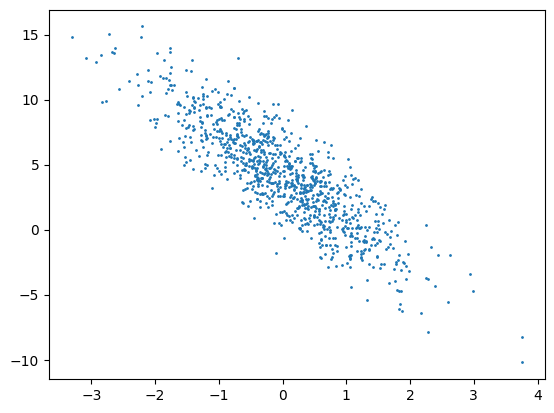

In [ ]:
# The semicolon is for displaying the plot only
plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1);

### Reading the Dataset

In the following code [**call upon the existing API in a framework to read data.**]
We pass in `features` and `labels` as arguments and specify `batch_size`
when instantiating a data iterator object.
Besides, the boolean value `is_train`
indicates whether or not
we want the data iterator object to shuffle the data
on each epoch (pass through the dataset).


1. **Use the tf function from_tensor_slices to generate a tf dataset object with batch_size as input**
2. **Use is_train flag to determine whether to shuffle the dataset or not, set the buffer size appropriately**

In [ ]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a TensorFlow data iterator."""
    #### YOUR CODE HERE ###
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)

    if is_train:
      dataset = dataset.shuffle(buffer_size= len(data_arrays[0]))

    dataset= dataset.batch(batch_size= batch_size)
    return dataset

In [ ]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [ ]:
array= (features, labels)
len(array[1])

1000

3. **Use `iter` to construct a Python iterator and use `next` to obtain the first item from the iterator.**


In [ ]:
### YOUR CODE HERE ###
my_iter= iter(data_iter)
first_item= next(my_iter)

first_item

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[-0.44109643,  0.29733023],
        [-0.37814665, -0.6147702 ],
        [-0.06459253,  0.17957735],
        [-1.2765387 , -0.67146075],
        [ 0.7718837 ,  1.4932712 ],
        [ 0.19340073, -0.240537  ],
        [ 1.6647202 , -1.199883  ],
        [ 1.0729338 , -0.04161261],
        [-0.05411331,  0.14211723],
        [-0.3459695 , -0.5312256 ]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[ 2.2935514],
        [ 5.5324187],
        [ 3.4383585],
        [ 3.9346645],
        [ 0.6701123],
        [ 5.3922973],
        [11.598939 ],
        [ 6.4856396],
        [ 3.6075172],
        [ 5.282805 ]], dtype=float32)>)

4. **Explain what the output shape in the prvious tensors means:**


**Answer:** The first tensor shape=(10, 2) this means 10 rows or 10 data points which equals the batch size , and 2 columns for the 2 features representing each data point.

The second tensor shape= (10, 1) representing the labels of the the 10 data points



5. **How many batches are in the **ENTIRE** data_iter ?**

**Answer:**  Number of batches = total data points / batch size = 1000 / 10 = 100

### Initializing Model Parameters

6. **Initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.02, and setting the bias to 0.**

Note: For the shapes of the weights and bias, look at the generating a dataset part


In [ ]:
## YOUR CODE HERE ##
weights = tf.Variable(tf.random.normal(shape=(features.shape[1], 1), mean=0, stddev=0.02), trainable=True)
bias = tf.Variable(0.0, dtype=tf.float32, trainable=True)

### Defining the Model

7. [**define our model, relating its inputs and parameters to its outputs.**]

In [ ]:
def linreg(X, w, b):
    """
    The linear regression model.
    Input:
    - X: input matrix
    - w: weights
    - bias
    """
    ## YOUR CODE HERE ##
    y_hat = tf.matmul(X, w) +b

    return y_hat

### Defining the Loss Function

8. (**define the loss function**): the squared loss function
as described in Loss Function definition above.

Note: In the implementation, you need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following function
will also have the same shape as `y_hat`.


In [ ]:
def squared_loss(y_hat, y):
    """Squared loss."""
    ## YOUR CODE HERE ##
    y = tf.reshape(y, shape=(-1, 1))

    loss = 0.5 * tf.reduce_mean(tf.square(y_hat - y))

    return loss

### Defining the Optimization Algorithm

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters
in the direction that may reduce the loss.

9. **Filll in the missing function below to apply the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size.**

This function should return nothing

Note: use assign_sub


In [ ]:
def sgd(params, grads, lr, batch_size):
    """Minibatch stochastic gradient descent."""

    ## YOUR CODE HERE ##
    for param, grad in zip([weights, bias], grads):
      param.assign_sub(lr * grad / batch_size)


### Training

10. **Implement the following loop**

* For each epoch :
    * For each batch in data_iter:
        * Compute the loss
        * Compute gradient
        * Update parameters
    * Calculate and print the training loss at the end of each epoch



Loss = $ l({x}, {y}) $

Gradient => $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$

Parameters update => $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
.

Don't forget to use GradientTape

Set the number of epochs `num_epochs` and the learning rate `lr` to 5 and 0.02, respectively.

In [ ]:
lr = 0.02
num_epochs = 5
net = linreg
loss = squared_loss

In [ ]:
## YOUR CODE HERE ## The loop code
for epoch in range(num_epochs):
    total_loss = 0.0
    for X, y in data_iter:
        with tf.GradientTape() as tape:
            # Forward pass
            # print(X.shape, weights.shape)
            y_hat = linreg(X, weights, bias)
            # Compute the squared loss
            loss = squared_loss(y_hat, y)
        # Calculate gradients
        grads = tape.gradient(loss, [weights, bias])
        # Update parameters using SGD
        sgd([weights, bias], grads, lr, batch_size)
        total_loss += tf.reduce_sum(loss)
    # Calculate and print the training loss
    average_loss = total_loss / len(y)
    print(f"Epoch {epoch + 1}, Loss: {average_loss}")

Epoch 1, Loss: 131.04808044433594
Epoch 2, Loss: 89.64685821533203
Epoch 3, Loss: 61.3724479675293
Epoch 4, Loss: 42.03944396972656
Epoch 5, Loss: 28.811138153076172


In this case, because we synthesized the dataset ourselves,
we know precisely what the true parameters are.

11. [**evaluate our success in training by comparing the true parameters with those that we learned through our training loop**] (final w, b). They should turn out to be very close to each other.

calculate the difference!!

 **they can be better with more epochs**

In [ ]:
## YOUR CODE HERE ##
error_w = tf.abs(true_w - weights[:,0])
error_b = tf.abs(true_b - bias)
print(f'error in estimating w: {error_w}')
print(f'error in estimating b: {error_b}')

error in estimating w: [0.90413284 1.308919  ]
error in estimating b: 1.585597038269043


## Diabetes Dataset

In this section, we will use SKLEARN's Diabetes dataset

### Loading the Dataset

1. **Load the Diabetes dataset from sklearn**

In [ ]:
from sklearn.datasets import load_diabetes
## YOUR CODE HERE ##
# Load the diabetes dataset

diabetes = load_diabetes()

2. **Look at the keys of diabetes_dataset dictionary**

In [ ]:
## YOUR CODE HERE ##

### Look at keys to determine the data
diabetes.keys()


dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

3. **Use the key DESCR to understand the dataset**

In [ ]:
## YOUR CODE HERE ##
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

4. **Save the data and target variables in numpy arrays and print their shapes**

In [ ]:
### START CODE HERE ### (≈ 2 lines of code)
data = diabetes.data
targets = diabetes.target
### END CODE HERE ###

print ('The shape of data is: ' + str(data.shape))
print ('The shape of targets is: ' + str(targets.shape))
print ('I have f = %d features!' % (data.shape[1]))
print ('I have m = %d examples!' % (data.shape[0]))

The shape of data is: (442, 10)
The shape of targets is: (442,)
I have f = 10 features!
I have m = 442 examples!


5. **What are the ranges of each column in features and the target column?**
    - *Hint* you might find it helpful to convert to pandas dataframe and use ".describe"

In [ ]:
### START CODE HERE ###
data_df = pd.DataFrame(data, columns=diabetes.feature_names)
targets_df = pd.DataFrame(targets, columns=['target'])

data_description = data_df.describe()
targets_description = targets_df.describe()
# print(data_description)
feature_ranges = data_description.loc[['min', 'max']]
target_range = targets_description.loc[['min', 'max']]

print("Ranges for Features:")
print(feature_ranges)
print("\nRange for Target Column:")
print(target_range)
### END CODE HERE ###

Ranges for Features:
          age       sex       bmi        bp        s1        s2        s3  \
min -0.107226 -0.044642 -0.090275 -0.112399 -0.126781 -0.115613 -0.102307   
max  0.110727  0.050680  0.170555  0.132044  0.153914  0.198788  0.181179   

           s4        s5        s6  
min -0.076395 -0.126097 -0.137767  
max  0.185234  0.133597  0.135612  

Range for Target Column:
     target
min    25.0
max   346.0


### Preparing the data

6. **Split the data into train and test set using sklearn train_test_split.** Have the test set as 10% of data

In [ ]:
np.random.seed(0)
### START CODE HERE ###
# Split the data into train and test sets
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

### END CODE HERE ###

print("Shape of training data is", train_data.shape)
print("Shape of training targets is", train_targets.shape)
print("Shape of test data is", test_data.shape)
print("Shape of test targets is", test_targets.shape)

Shape of training data is (397, 10)
Shape of training targets is (397,)
Shape of test data is (45, 10)
Shape of test targets is (45,)


- *feature-wise normalization*: for each feature in the input data (a column in the input data matrix), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in NumPy.
- **Question:** Should we normalize features? WHY?
    - ANSWER:
     Normalizing features helps prevent issues related to feature scales and can lead to faster convergence, However the features have already been normalized as the description of the data states: "Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times the square root of `n_samples` (i.e. the sum of squares of each column totals 1)"

7. **normalize the targets**

In [ ]:
### START CODE HERE ### (≈ 6 lines of code)

train_target_mean = train_targets.mean()
train_target_std = train_targets.std()

test_target_mean = test_targets.mean()
test_target_std = test_targets.std()

normalized_train_targets = (train_targets - train_target_mean) / train_target_std
normalized_test_targets = (test_targets - test_target_mean) / test_target_std



### END CODE HERE ###

### Building your model

7. **Use tf.keras.Sequential to build a model with:**
    - 6 hidden layers each having 128 neurons and relu activation.
    - 1 output layer
    - use input_shape argument to specify input size in 1st layer
- **Question:** How many neurons should be in output layer? What should be the activation?
    - ANSWER: as it is a regression problem we need one neuron only with no activation function (linear regression)

In [ ]:
def build_model(input_shape):
    ### START CODE HERE ### ()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape))
    for _ in range(6):
        model.add(tf.keras.layers.Dense(128, activation='relu'))

    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
# Print the model summary
input_shape= train_data.shape[1]
model = build_model(input_shape)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 1)                 1

8. **Compile the model using optimizer=Adam, loss=mean squared loss, metrics=mean absoluute error:**

In [ ]:
### START CODE HERE ### ()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])


Note that we compile the model with the mse loss function—mean squared error, the
square of the difference between the predictions and the targets. We’re also monitoring a new metric during training: mean absolute error (MAE). It’s the
absolute value of the difference between the predictions and the targets.

9. **FIT the model using for 110 epochs, 64 batch size and a validation split of 0.1**

In [ ]:
### START CODE HERE ### ()
history= model.fit(train_data, normalized_train_targets, epochs=110, batch_size=64, validation_split=0.1)

Epoch 1/110
6/6 [==============================] - 2s 74ms/step - loss: 0.9645 - mean_absolute_error: 0.8377 - val_loss: 1.1388 - val_mean_absolute_error: 0.9173
Epoch 2/110
6/6 [==============================] - 0s 17ms/step - loss: 0.8682 - mean_absolute_error: 0.7910 - val_loss: 0.9317 - val_mean_absolute_error: 0.8327
Epoch 3/110
6/6 [==============================] - 0s 13ms/step - loss: 0.6670 - mean_absolute_error: 0.6764 - val_loss: 0.6564 - val_mean_absolute_error: 0.6928
Epoch 4/110
6/6 [==============================] - 0s 16ms/step - loss: 0.5381 - mean_absolute_error: 0.6057 - val_loss: 0.5494 - val_mean_absolute_error: 0.6119
Epoch 5/110
6/6 [==============================] - 0s 17ms/step - loss: 0.4706 - mean_absolute_error: 0.5543 - val_loss: 0.5662 - val_mean_absolute_error: 0.6550
Epoch 6/110
6/6 [==============================] - 0s 17ms/step - loss: 0.4826 - mean_absolute_error: 0.5635 - val_loss: 0.5307 - val_mean_absolute_error: 0.6093
Epoch 7/110
6/6 [===========

In [ ]:
# Evaluate the model on the test set
test_loss, test_mean_absolute_error = model.evaluate(test_data, normalized_test_targets)

print(f'Test Loss: {test_loss}')
print(f'Test Mean Absolute Error: {test_mean_absolute_error}')

2/2 [==============================] - 0s 7ms/step - loss: 0.8721 - mean_absolute_error: 0.7477
Test Loss: 0.8721100091934204
Test Mean Absolute Error: 0.7477282881736755


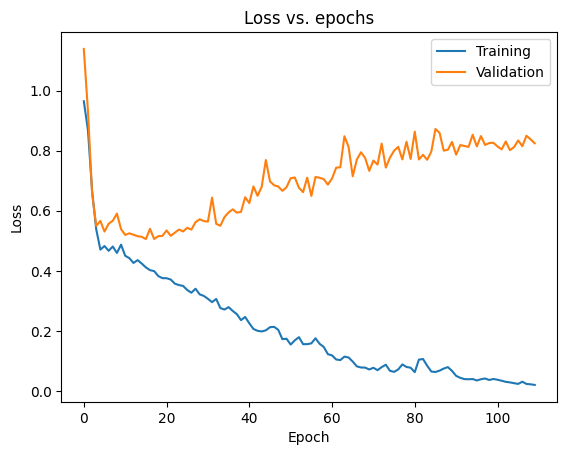

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot( history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

9. **Diagnose the learning curve:**
    - Why is the validation loss much higher than training loss?
    - What's this phenomenon called?
    - Mention 3 methods to reduce this.

- **answer**:
    ___
    - this means that the model learns to perform well on the training data and memorize it but does not generalize well to unseen data
    ___
    - overfitting
    ___
    - Regularization (like L1 or L2) as a penality added to the loss function
    - Reducing model complexity (the more complexity= more learning = more likely to overfit)
    - Early Stopping (stopping the training if the val_loss starts to increase)

10. **Use one of the methods you mentioned and retrain the model then plot the learning curves**

Epoch 1/110
6/6 [==============================] - 5s 91ms/step - loss: 7.2648 - mean_absolute_error: 0.8415 - val_loss: 7.0292 - val_mean_absolute_error: 0.9375
Epoch 2/110
6/6 [==============================] - 0s 23ms/step - loss: 6.5370 - mean_absolute_error: 0.8336 - val_loss: 6.3352 - val_mean_absolute_error: 0.9278
Epoch 3/110
6/6 [==============================] - 0s 14ms/step - loss: 5.8690 - mean_absolute_error: 0.8224 - val_loss: 5.6954 - val_mean_absolute_error: 0.9121
Epoch 4/110
6/6 [==============================] - 0s 10ms/step - loss: 5.2549 - mean_absolute_error: 0.8041 - val_loss: 5.0998 - val_mean_absolute_error: 0.8902
Epoch 5/110
6/6 [==============================] - 0s 9ms/step - loss: 4.6878 - mean_absolute_error: 0.7736 - val_loss: 4.5220 - val_mean_absolute_error: 0.8412
Epoch 6/110
6/6 [==============================] - 0s 16ms/step - loss: 4.1306 - mean_absolute_error: 0.7167 - val_loss: 3.9596 - val_mean_absolute_error: 0.7619
Epoch 7/110
6/6 [============

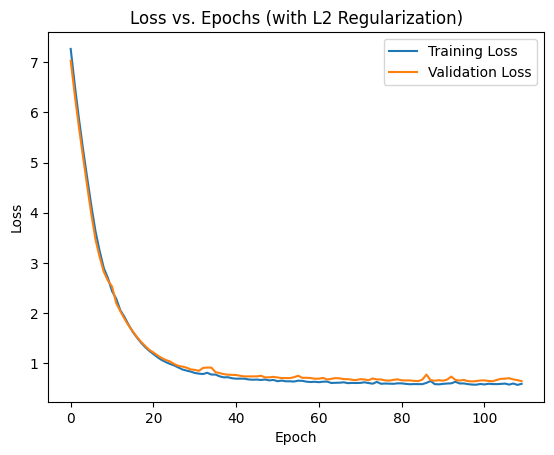

In [ ]:
#### YOUR CODE HERE
from tensorflow.keras.regularizers import l2

# Building the model with L2 regularization with 0.01 strength in each layer
#  I tried also 0.05 and 0.1 but 0.01 is the best as the rest affected the training loss negatively (underfitting)
def build_regularized_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(input_shape,)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    return model

regularized_model = build_regularized_model(train_data.shape[1])

regularized_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

history = regularized_model.fit(train_data, normalized_train_targets, epochs=110, batch_size=64, validation_split=0.1)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs (with L2 Regularization)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



Epoch 1/110
6/6 [==============================] - 1s 50ms/step - loss: 4.8213 - mean_absolute_error: 0.8400 - val_loss: 4.7534 - val_mean_absolute_error: 0.9331
Epoch 2/110
6/6 [==============================] - 0s 11ms/step - loss: 4.3662 - mean_absolute_error: 0.8290 - val_loss: 4.3181 - val_mean_absolute_error: 0.9206
Epoch 3/110
6/6 [==============================] - 0s 10ms/step - loss: 3.9478 - mean_absolute_error: 0.8152 - val_loss: 3.9078 - val_mean_absolute_error: 0.9017
Epoch 4/110
6/6 [==============================] - 0s 10ms/step - loss: 3.5560 - mean_absolute_error: 0.7937 - val_loss: 3.5207 - val_mean_absolute_error: 0.8774
Epoch 5/110
6/6 [==============================] - 0s 13ms/step - loss: 3.1890 - mean_absolute_error: 0.7635 - val_loss: 3.1365 - val_mean_absolute_error: 0.8314
Epoch 6/110
6/6 [==============================] - 0s 11ms/step - loss: 2.8233 - mean_absolute_error: 0.7078 - val_loss: 2.7632 - val_mean_absolute_error: 0.7634
Epoch 7/110
6/6 [===========

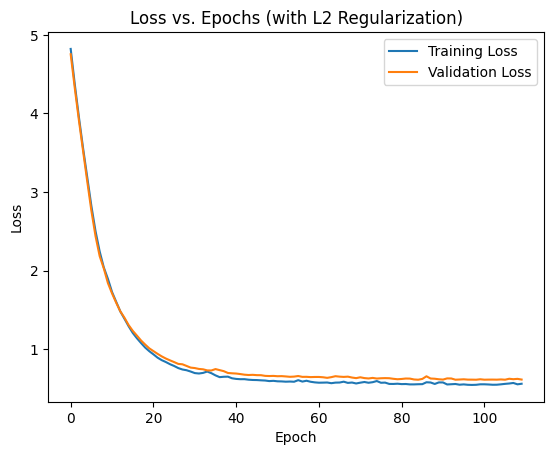

In [ ]:
#trying to so the same but with simpler model
#### YOUR CODE HERE
from tensorflow.keras.regularizers import l2

def build_regularized_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(input_shape,)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    return model

regularized_model = build_regularized_model(train_data.shape[1])

regularized_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

history = regularized_model.fit(train_data, normalized_train_targets, epochs=110, batch_size=64, validation_split=0.1)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs (with L2 Regularization)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



# Part 3 Batches and Epochs

In this part of the assignment we will create a synthetic data to play with.
The data will have 2 features and 3 target classes --> multiclass classification problem

In [ ]:
# prepare train and test dataset
def prepare_data():
    #  generate classification dataset with 3 centers (labels/classes)
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

    # plot data
    for class_value in range(3):
        # select indices of points with the class label
        row_ix = np.where(y == class_value)
        # scatter plot for points with a different color
        plt.scatter(X[row_ix, 0], X[row_ix, 1])
    # show plot
    plt.show()

    # one hot encode output variable to convert from integers to binary class
    y = to_categorical(y)

    # split into train and test
    n_train = 500
    X_train, X_test = X[:n_train, :], X[n_train:, :]
    y_train, y_test = y[:n_train], y[n_train:]
    return X_train, y_train, X_test, y_test


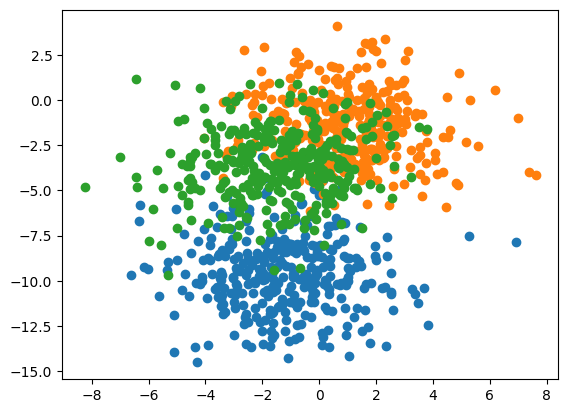

In [ ]:
# prepare dataset
X_train, y_train, X_test, y_test = prepare_data()


- **Create a model with:**
    -  1 hidden dense layer (50 neurons), activation relu, , kernel_initializer he_uniform
    - 1 output layer
    - compile the model with SGD (learning rate 0.01 and momentum 0.9) optimizer and categorical crossentropy and accuracy inside build function

In [ ]:
def build_model():

    ##### YOUR CODE HERE
    model = Sequential()
    model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=2))
    model.add(Dense(3, activation='softmax'))
    sgd = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])



    return model

- Create a function to fit and build the model with different batch sizes

Use epochs = 125

In [ ]:
# fit a model and plot learning curve
def fit_model(X_train, y_train, X_test, y_test, n_batch):
    ##### YOUR CODE HERE
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=125, batch_size=n_batch)


    return history

### Hyperparameter Tuning

#### Batch size

##### Size =  1

10. **train for 1 batch size**

In [ ]:
### START CODE HERE ###

batch_size = 1
model= build_model()
history = fit_model(X_train, y_train, X_test, y_test, batch_size)

###### END CODE HERE

Epoch 1/125
500/500 [==============================] - 2s 3ms/step - loss: 1.6355 - accuracy: 0.5460 - val_loss: 0.9264 - val_accuracy: 0.5000
Epoch 2/125
500/500 [==============================] - 1s 3ms/step - loss: 1.0579 - accuracy: 0.5240 - val_loss: 1.0970 - val_accuracy: 0.5280
Epoch 3/125
500/500 [==============================] - 1s 3ms/step - loss: 1.0292 - accuracy: 0.4720 - val_loss: 1.0061 - val_accuracy: 0.5760
Epoch 4/125
500/500 [==============================] - 1s 3ms/step - loss: 1.0739 - accuracy: 0.4940 - val_loss: 0.9795 - val_accuracy: 0.5240
Epoch 5/125
500/500 [==============================] - 2s 4ms/step - loss: 0.9369 - accuracy: 0.5280 - val_loss: 1.0791 - val_accuracy: 0.5520
Epoch 6/125
500/500 [==============================] - 2s 3ms/step - loss: 0.9225 - accuracy: 0.5300 - val_loss: 0.8979 - val_accuracy: 0.6180
Epoch 7/125
500/500 [==============================] - 1s 3ms/step - loss: 0.9708 - accuracy: 0.5020 - val_loss: 0.8912 - val_accuracy: 0.5900

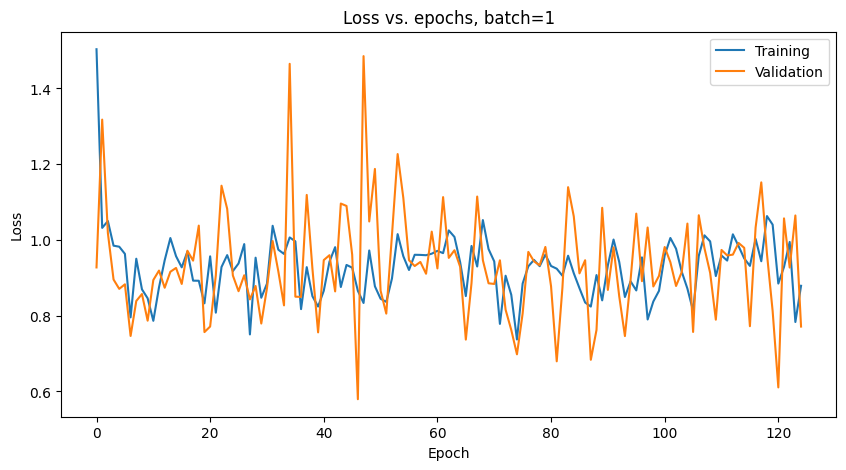

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

- **Diagnose this curve w.r.t learning rate**:
    - ANSWER:  the training loss and the validation loss is high and unstable (goes up and down), so the model isn't learning or generalizing well.
     I think due to the high learning rate, the model converges too quickly and skips (overshoots) the optimal parameters.
- Change learning rate to make this curve better

In [ ]:
### Your answer
lr= 0.001

In [ ]:
def build_model():

    ##### YOUR CODE HERE
    model = Sequential()
    model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=2))
    model.add(Dense(3, activation='softmax'))
    sgd = SGD(learning_rate=lr, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return model

Epoch 1/125
500/500 [==============================] - 3s 5ms/step - loss: 2.2812 - accuracy: 0.5720 - val_loss: 0.9096 - val_accuracy: 0.6880
Epoch 2/125
500/500 [==============================] - 1s 3ms/step - loss: 1.0571 - accuracy: 0.6820 - val_loss: 0.6337 - val_accuracy: 0.7900
Epoch 3/125
500/500 [==============================] - 1s 3ms/step - loss: 0.7965 - accuracy: 0.6940 - val_loss: 0.7211 - val_accuracy: 0.7220
Epoch 4/125
500/500 [==============================] - 1s 3ms/step - loss: 0.6198 - accuracy: 0.7560 - val_loss: 0.7035 - val_accuracy: 0.7080
Epoch 5/125
500/500 [==============================] - 1s 3ms/step - loss: 0.5867 - accuracy: 0.7700 - val_loss: 0.4714 - val_accuracy: 0.8160
Epoch 6/125
500/500 [==============================] - 1s 3ms/step - loss: 0.4963 - accuracy: 0.7840 - val_loss: 0.4279 - val_accuracy: 0.8220
Epoch 7/125
500/500 [==============================] - 3s 6ms/step - loss: 0.4990 - accuracy: 0.7900 - val_loss: 0.4454 - val_accuracy: 0.7980

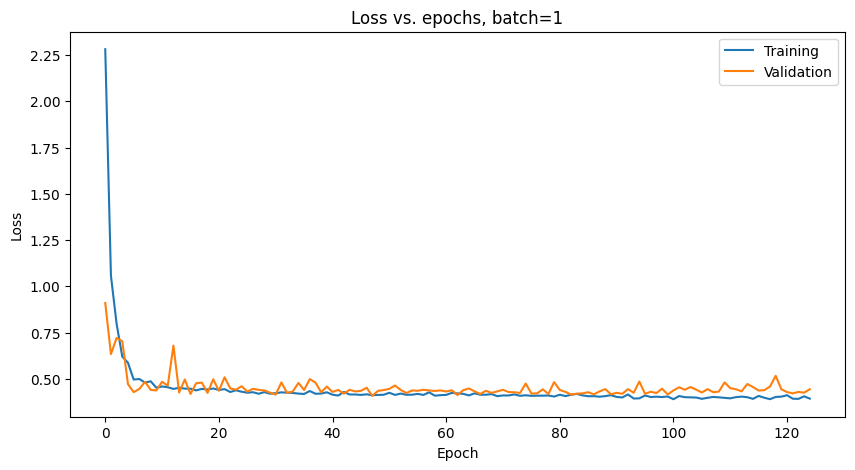

In [ ]:
batch_size = 1
model= build_model()
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  16

10. **Retrain for 16 batch size**

In [ ]:
### START CODE HERE ###
model= build_model()
batch_size = 16
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

Epoch 1/125
32/32 [==============================] - 1s 10ms/step - loss: 1.5881 - accuracy: 0.5440 - val_loss: 0.6844 - val_accuracy: 0.6840
Epoch 2/125
32/32 [==============================] - 0s 5ms/step - loss: 0.9164 - accuracy: 0.5700 - val_loss: 0.9409 - val_accuracy: 0.6200
Epoch 3/125
32/32 [==============================] - 0s 5ms/step - loss: 0.8048 - accuracy: 0.6100 - val_loss: 0.6334 - val_accuracy: 0.6820
Epoch 4/125
32/32 [==============================] - 0s 4ms/step - loss: 0.7163 - accuracy: 0.6460 - val_loss: 0.6341 - val_accuracy: 0.7140
Epoch 5/125
32/32 [==============================] - 0s 5ms/step - loss: 0.6762 - accuracy: 0.6620 - val_loss: 0.6533 - val_accuracy: 0.6680
Epoch 6/125
32/32 [==============================] - 0s 5ms/step - loss: 0.6772 - accuracy: 0.6560 - val_loss: 0.6899 - val_accuracy: 0.6620
Epoch 7/125
32/32 [==============================] - 0s 5ms/step - loss: 0.7076 - accuracy: 0.6600 - val_loss: 0.6585 - val_accuracy: 0.6720
Epoch 8/125


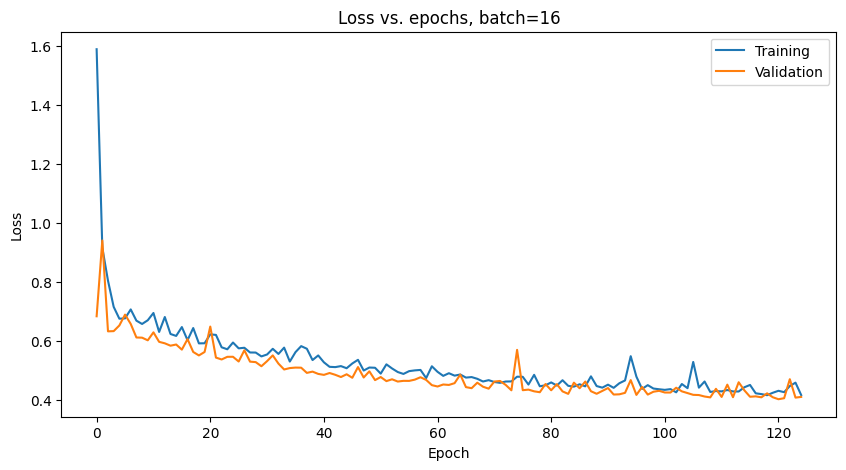

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  128

10. **Retrain for 128 batch size**

In [ ]:
### START CODE HERE ###
model= build_model()
batch_size = 128
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

Epoch 1/125
4/4 [==============================] - 1s 65ms/step - loss: 2.1539 - accuracy: 0.3280 - val_loss: 1.5645 - val_accuracy: 0.4260
Epoch 2/125
4/4 [==============================] - 0s 15ms/step - loss: 1.4251 - accuracy: 0.4180 - val_loss: 1.0780 - val_accuracy: 0.5040
Epoch 3/125
4/4 [==============================] - 0s 18ms/step - loss: 1.3182 - accuracy: 0.4000 - val_loss: 1.0256 - val_accuracy: 0.5520
Epoch 4/125
4/4 [==============================] - 0s 20ms/step - loss: 1.1040 - accuracy: 0.4740 - val_loss: 1.1050 - val_accuracy: 0.4860
Epoch 5/125
4/4 [==============================] - 0s 19ms/step - loss: 1.0267 - accuracy: 0.4760 - val_loss: 0.7852 - val_accuracy: 0.6560
Epoch 6/125
4/4 [==============================] - 0s 13ms/step - loss: 0.9077 - accuracy: 0.5180 - val_loss: 0.8105 - val_accuracy: 0.6740
Epoch 7/125
4/4 [==============================] - 0s 18ms/step - loss: 0.8370 - accuracy: 0.5800 - val_loss: 0.8046 - val_accuracy: 0.5960
Epoch 8/125
4/4 [===

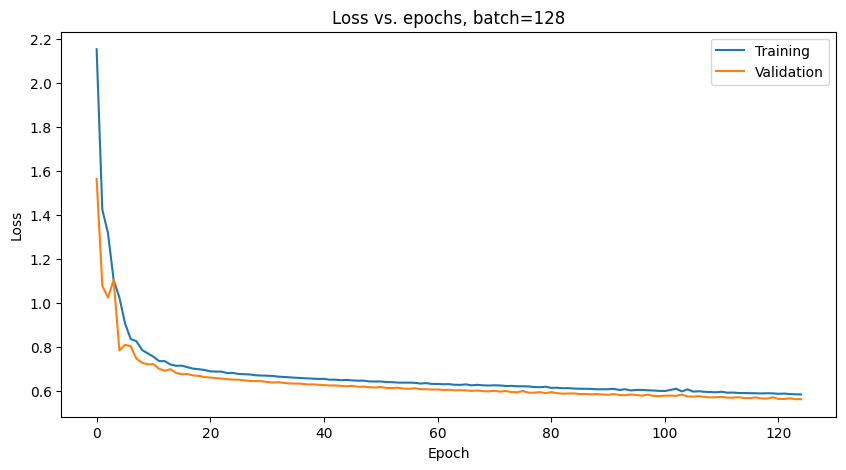

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  Data

10. **Retrain for length of data batch size**

In [ ]:
### START CODE HERE ###
batch_size =  len(y_train)
model= build_model()
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

Epoch 1/125
1/1 [==============================] - 1s 564ms/step - loss: 2.9489 - accuracy: 0.3100 - val_loss: 3.0666 - val_accuracy: 0.2880
Epoch 2/125
1/1 [==============================] - 0s 59ms/step - loss: 2.8864 - accuracy: 0.3120 - val_loss: 2.9558 - val_accuracy: 0.2900
Epoch 3/125
1/1 [==============================] - 0s 43ms/step - loss: 2.7693 - accuracy: 0.3140 - val_loss: 2.8027 - val_accuracy: 0.2940
Epoch 4/125
1/1 [==============================] - 0s 46ms/step - loss: 2.6071 - accuracy: 0.3200 - val_loss: 2.6202 - val_accuracy: 0.3020
Epoch 5/125
1/1 [==============================] - 0s 62ms/step - loss: 2.4135 - accuracy: 0.3200 - val_loss: 2.4334 - val_accuracy: 0.3180
Epoch 6/125
1/1 [==============================] - 0s 61ms/step - loss: 2.2142 - accuracy: 0.3260 - val_loss: 2.3068 - val_accuracy: 0.3360
Epoch 7/125
1/1 [==============================] - 0s 47ms/step - loss: 2.0746 - accuracy: 0.3480 - val_loss: 2.3272 - val_accuracy: 0.2020
Epoch 8/125
1/1 [==

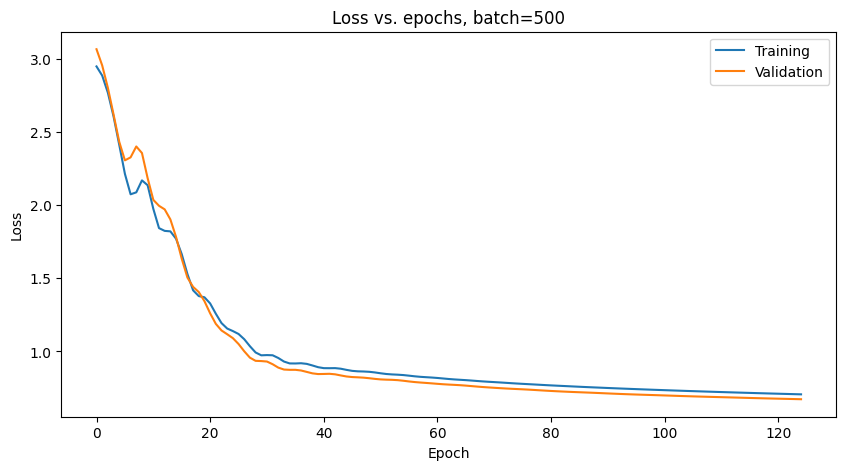

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing batch size have on learning in terms of convergence and fluctuations?**

**Answer:**
Very small batch sizes lead to noisy updates, slower convergence, and more fluctuations. Very large batch sizes result in smoother training but take more epochs to converge. The ideal batch size is a trade-off that balances reasonable convergence speed without introducing excessive noise.



#### Learning Rate

batch size 64

- **Use same code for build_model above, add an argument learning rate to change learning rate of optmizer**

In [ ]:
def build_model(lr):

    ##### YOUR CODE HERE
    model = Sequential()
    model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=2))
    model.add(Dense(3, activation='softmax'))
    sgd = SGD(learning_rate=lr, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return model

##### LR =  0.00001

10. **Retrain for 0.00001 LR**

In [ ]:
### START CODE HERE ### ()
lr= 0.00001
model = build_model(lr)
batch_size = 64
history = fit_model(X_train, y_train, X_test, y_test, batch_size)

Epoch 1/125
8/8 [==============================] - 2s 80ms/step - loss: 3.6276 - accuracy: 0.2680 - val_loss: 3.1902 - val_accuracy: 0.3060
Epoch 2/125
8/8 [==============================] - 0s 28ms/step - loss: 3.3288 - accuracy: 0.2680 - val_loss: 2.8401 - val_accuracy: 0.3060
Epoch 3/125
8/8 [==============================] - 0s 31ms/step - loss: 2.9316 - accuracy: 0.2680 - val_loss: 2.4824 - val_accuracy: 0.3020
Epoch 4/125
8/8 [==============================] - 0s 23ms/step - loss: 2.5912 - accuracy: 0.2760 - val_loss: 2.2102 - val_accuracy: 0.3220
Epoch 5/125
8/8 [==============================] - 0s 26ms/step - loss: 2.3564 - accuracy: 0.4120 - val_loss: 2.0618 - val_accuracy: 0.5460
Epoch 6/125
8/8 [==============================] - 0s 22ms/step - loss: 2.2364 - accuracy: 0.5040 - val_loss: 1.9809 - val_accuracy: 0.5260
Epoch 7/125
8/8 [==============================] - 0s 22ms/step - loss: 2.1626 - accuracy: 0.4920 - val_loss: 1.9248 - val_accuracy: 0.5100
Epoch 8/125
8/8 [===

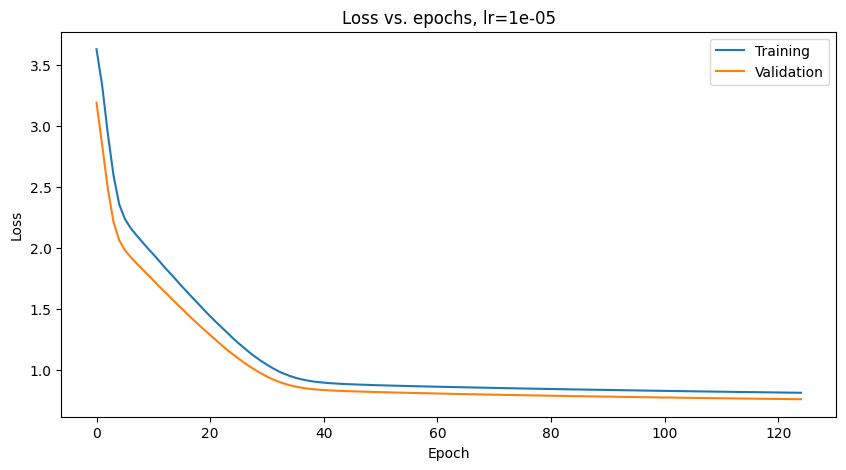

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, lr=' +str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.001

10. **Retrain for 0.001 LR**

In [ ]:
### START CODE HERE ### ()
lr= 0.001
model= build_model(lr)
batch_size = 64
history = fit_model(X_train, y_train, X_test, y_test, batch_size)


Epoch 1/125
8/8 [==============================] - 4s 127ms/step - loss: 6.0265 - accuracy: 0.2300 - val_loss: 3.6991 - val_accuracy: 0.3520
Epoch 2/125
8/8 [==============================] - 0s 35ms/step - loss: 4.3322 - accuracy: 0.3600 - val_loss: 2.5547 - val_accuracy: 0.3580
Epoch 3/125
8/8 [==============================] - 0s 29ms/step - loss: 2.3210 - accuracy: 0.3520 - val_loss: 1.9156 - val_accuracy: 0.3820
Epoch 4/125
8/8 [==============================] - 0s 33ms/step - loss: 1.5319 - accuracy: 0.4480 - val_loss: 1.1548 - val_accuracy: 0.5360
Epoch 5/125
8/8 [==============================] - 0s 35ms/step - loss: 1.1962 - accuracy: 0.5420 - val_loss: 0.8527 - val_accuracy: 0.7020
Epoch 6/125
8/8 [==============================] - 0s 30ms/step - loss: 1.0112 - accuracy: 0.5900 - val_loss: 0.9501 - val_accuracy: 0.5980
Epoch 7/125
8/8 [==============================] - 0s 24ms/step - loss: 0.9331 - accuracy: 0.6040 - val_loss: 0.8048 - val_accuracy: 0.6940
Epoch 8/125
8/8 [==

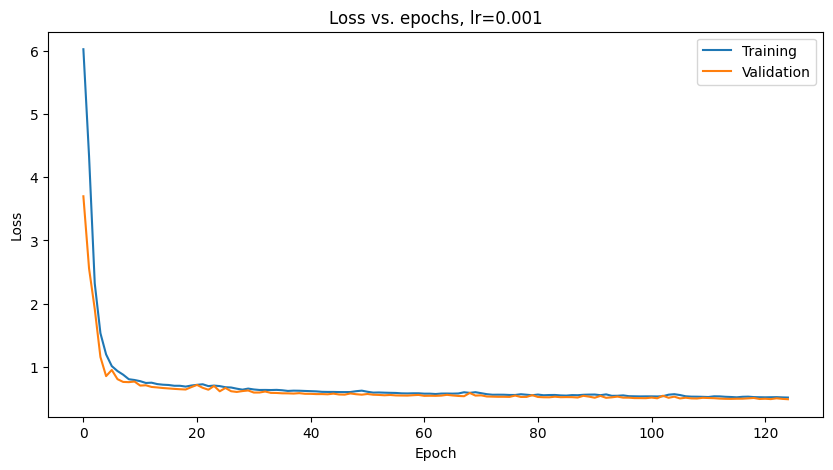

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, lr=' +str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.1

10. **Retrain for 0.1 LR**

In [ ]:
### START CODE HERE ### ()
lr= 0.1
model= build_model(lr)
batch_size = 64
history = fit_model(X_train, y_train, X_test, y_test, batch_size)

Epoch 1/125
8/8 [==============================] - 1s 57ms/step - loss: 13.5637 - accuracy: 0.4140 - val_loss: 6.0069 - val_accuracy: 0.4760
Epoch 2/125
8/8 [==============================] - 0s 25ms/step - loss: 5.9356 - accuracy: 0.4460 - val_loss: 5.3607 - val_accuracy: 0.4220
Epoch 3/125
8/8 [==============================] - 0s 21ms/step - loss: 2.1974 - accuracy: 0.4660 - val_loss: 1.1387 - val_accuracy: 0.5800
Epoch 4/125
8/8 [==============================] - 0s 19ms/step - loss: 1.2761 - accuracy: 0.5380 - val_loss: 1.1737 - val_accuracy: 0.5700
Epoch 5/125
8/8 [==============================] - 0s 18ms/step - loss: 1.2264 - accuracy: 0.5540 - val_loss: 1.0967 - val_accuracy: 0.6300
Epoch 6/125
8/8 [==============================] - 0s 19ms/step - loss: 1.1255 - accuracy: 0.6120 - val_loss: 1.0435 - val_accuracy: 0.6620
Epoch 7/125
8/8 [==============================] - 0s 17ms/step - loss: 1.0761 - accuracy: 0.6400 - val_loss: 0.9481 - val_accuracy: 0.6660
Epoch 8/125
8/8 [==

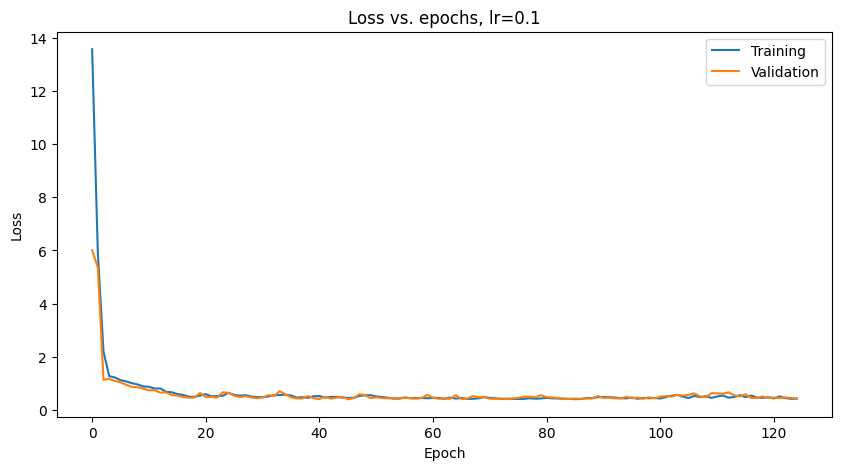

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, lr=' +str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing learning rate have on learning?**





**Answer:**

Higher learning rate: larger steps, convergence can be hard , more sensitive to noise.
</br>

Lower learning rate: less sensitive to noise, slower convergence but 100% will converge due to smaller steps.

**Questions**

1. Mention 1 advantage of a computational graph?

**Answer:**
It breaks down complex mathematical operations into smaller, modular components, allowing for parallelization and optimization so it computes gradients and chain-rule differentiations for the models training in so efficient way

2. Mention two ways to input data for training using TensorFlow if the data resides on disk

**Answer:**
1. ______________
tf.data.Dataset: an API to create input pipelines from various file formats stored on disk efficiently.

2. ____________
tf.keras.utils.get_file(): to download and cache data from the internet or a local source. This function retrieves and stores the data on the local disk.